# Pulmonary Fibrosis Progression (I)

## Analysis of tabular data

In this notebook we are exploring the input data to get a better understanding on the main properties and the correlelation between them.

Some of the questions we are going to be answering:


In [1]:
## Imports

import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#plotly
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

from sklearn import preprocessing

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

### Overview of the train and test dataset
In this first section we are going to investigate both test and train datasets to get some of the basic information about it.

In [2]:
train_df = pd.read_csv( 'data/train.csv' )
test_df  = pd.read_csv( 'data/test.csv' )
print(f'[train_df] shape: {train_df.shape}')
print(f'[test_df] shape: {test_df.shape}')

[train_df] shape: (1549, 7)
[test_df] shape: (5, 7)


In [3]:
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
test_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [5]:
print(f'[train_df] Number of rows: {train_df["Patient"].count()}')
print(f'[train_df] Number of unique patients: {train_df["Patient"].unique().shape[0]}')
print(f'[test_df] Number of rows: {test_df["Patient"].count()}')
print(f'[test_df] Number of unique patients: {test_df["Patient"].value_counts().shape[0]}')
print(f'[train_df] SmokingStatus values: {train_df["SmokingStatus"].value_counts().index.tolist()}')
print(f'[test_df] SmokingStatus values: {test_df["SmokingStatus"].value_counts().index.tolist()}')

[train_df] Number of rows: 1549
[train_df] Number of unique patients: 176
[test_df] Number of rows: 5
[test_df] Number of unique patients: 5
[train_df] SmokingStatus values: ['Ex-smoker', 'Never smoked', 'Currently smokes']
[test_df] SmokingStatus values: ['Ex-smoker', 'Never smoked']


In [6]:
train_images_path = "data/train"
test_images_path = "data/test"
num_train_folders = 0
num_test_folders = 0
train_patient_array = np.array(os.listdir(train_images_path))
test_patient_array = np.array(os.listdir(test_images_path))

for root, dirnames, filenames in os.walk(train_images_path):
    num_train_folders += len(dirnames)
        
for root, dirnames,filenames in os.walk(test_images_path):
    num_test_folders += len(dirnames)
    
print(f'Number of train CT scan folders: {num_train_folders}')
print(f'Number of test CT scan folders: {num_test_folders}')
print(f'[TRAIN] Does every patient have a CT scan folder? '+
      ('yes :) ' if len(np.setdiff1d(train_df["Patient"].unique(), train_patient_array))==0 else 'No :('))
print(f'[TEST] Does every patient have a CT scan folder? '+
      ('yes :) ' if len(np.setdiff1d(test_df["Patient"].unique(), test_patient_array))==0 else 'No :('))

Number of train CT scan folders: 176
Number of test CT scan folders: 5
[TRAIN] Does every patient have a CT scan folder? yes :) 
[TEST] Does every patient have a CT scan folder? yes :) 


#### [Summary] Overview of tabular data

* Each of the rows in the train and test dataset contains information for a patient visit with details about:
 * Weeks- the relative number of weeks pre/post the baseline CT (may be negative)
 * FVC - the recorded lung capacity in ml
 * Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
 * Age
 * Sex
 * SmokingStatus
* SmokingStatus values
 * Ex-smoker
 * Never smoked
 * Currently smokes
* Train and test dataset contain 176 and 5 unique patients respectively.

#### [Summary] Overview of dicom data
* Every patient in the tabular data has a directory containing the images of the baseline CT scan.

### Analysis of the Tabular data
In this section we are going to look at the nature of the tabular data given as part of the input dataset. The main idea is understand better the distribution of the data per each of the identified features (FVC, percent, age, sex and smoking status). Also we are going to look at how the data changes in time by anaylising patient data between weeks.

In [7]:
# create patient dataframe: patient, baseline_fvc, baseline_percentage, age, sex, smoking status, num_visits
#Creating new rows
patients = []
age = []
sex = []
smoking_status = []
num_visits = []

#for each unique patient filter collect static data
for patient in train_df["Patient"].unique():
    patient_rows = train_df[train_df['Patient'] == patient]
    patient_row = patient_rows.iloc[0]
    patients.append(patient_row['Patient'])
    age.append(patient_row['Age'])
    sex.append(patient_row['Sex'])
    smoking_status.append(patient_row['SmokingStatus'])
    num_visits.append(patient_rows.shape[0])
    
patient_df = pd.DataFrame(list(zip(patients, age, sex, smoking_status, num_visits)), 
                                 columns =['Patient', 'Age', 'Sex', 'Smoking_Status', 'Num_Visits'])
print(patient_df.info())
patient_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Patient         176 non-null    object
 1   Age             176 non-null    int64 
 2   Sex             176 non-null    object
 3   Smoking_Status  176 non-null    object
 4   Num_Visits      176 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 7.0+ KB
None


,Patient,Age,Sex,Smoking_Status,Num_Visits
0,ID00007637202177411956430,79,Male,Ex-smoker,9
1,ID00009637202177434476278,69,Male,Ex-smoker,9
2,ID00010637202177584971671,60,Male,Ex-smoker,9
3,ID00011637202177653955184,72,Male,Ex-smoker,9
4,ID00012637202177665765362,65,Male,Never smoked,9


In [8]:
def plot_sex_distribution(patient_df):
    '''Plots sex distribution as a pie from patient_df
       :param patient_df: dataframe contianing patient information
       '''
    male_condition = patient_df['Sex'] == 'Male'
    female_condition = patient_df['Sex'] == 'Female'
    sex_distribution = pd.DataFrame({
        'Sex': ['Male', 'Female'], 
        'Count': [patient_df[male_condition]['Patient'].count(), patient_df[female_condition]['Patient'].count()]})
    fig = px.pie(sex_distribution, values='Count', names='Sex', title='Sex distribution')
    fig.show()
    
def plot_patient_df_age_over_sex(patient_df):
    '''Plots patients's age distributions from patient_df
       :param patient_df: dataframe contianing patient information
       '''
    # plot patient age distribution
    male_condition = patient_df['Sex'] == 'Male'
    female_condition = patient_df['Sex'] == 'Female'
    age_distribution_over_sex = pd.concat([patient_df[male_condition]['Age'].value_counts(),
                                           patient_df[female_condition]['Age'].value_counts()],
                                          axis=1, ignore_index=True).fillna(0)
    age_distribution_over_sex = age_distribution_over_sex.rename(columns={0: "Male", 1: "Female"})
    age_distribution_over_sex.iplot(kind='bar',
                                      xTitle='Age',
                                      yTitle='Counts',
                                      linecolor='black', 
                                      opacity=0.7,
                                      theme='pearl',
                                      bargap=0.3,
                                      barmode='stack',
                                      gridcolor='white',
                                      title='Age distribution over Sex')
    
def plot_patient_df_smoking_status_over_sex(patient_df):
    '''Plots patients's smoking status distributions 
       :param patient_df: dataframe contianing patient information
    '''
    # plot patient age distribution
    smoking_status_male = []
    smoking_status_female = []
    for smoking_status in patient_df['Smoking_Status'].unique():
        male_condition = (patient_df['Smoking_Status'] == smoking_status) & (patient_df['Sex'] == 'Male')
        female_condition = (patient_df['Smoking_Status'] == smoking_status) & (patient_df['Sex'] == 'Female')
        smoking_status_male.append(patient_df[male_condition]['Patient'].count())
        smoking_status_female.append(patient_df[female_condition]['Patient'].count())
    smoking_status_over_sex_distribution = pd.DataFrame({
        'Male': smoking_status_male, 
        'Female': smoking_status_female}, index=[patient_df['Smoking_Status'].unique()])
    smoking_status_over_sex_distribution.iplot(kind='bar',
                                      xTitle='Smoking Distribution',
                                      yTitle='Count (over Sex)',
                                      linecolor='black', 
                                      opacity=0.7,
                                      theme='pearl',
                                      bargap=0.3,
                                      barmode='stack',
                                      gridcolor='white',
                                      title='Smoking distribution over Sex')

plot_sex_distribution(patient_df) 
plot_patient_df_age_over_sex(patient_df)
plot_patient_df_smoking_status_over_sex(patient_df)

#### [Conclusions] Sex, Age and Smoking Status Distribution conclusions
* Almost 80% of patients in our train dataset are males
* The majority of the patients are aged between 60 and 75 
* The majority of the patients are ex-smokers and males

In [9]:
def plot_capacity_type_per_age(data_df, capacity_type='FVC'):
    '''Plots the capacity type per age
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    fig = px.scatter(train_df, x=capacity_type, y="Age", color='Age', title=f'Distribution of {capacity_type} per age')
    fig.show()

def plot_capacity_type_per_sex(data_df, capacity_type='FVC'):
    '''Plots the fvc per sex
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    hist_data = [data_df.groupby('Sex').get_group('Male')[capacity_type],
                 data_df.groupby('Sex').get_group('Female')[capacity_type]]
    
    group_labels = ['Male', 'Female']
    colors = ['orange', 'blue']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors,bin_size=bins_per_capacity_type(capacity_type),
                             show_curve=True)

    fig.update(layout_title_text=f'Distribution of {capacity_type} per Sex')
    fig.show()
    
def plot_capacity_type_per_smoking_status(data_df, capacity_type='FVC'):
    '''Plots the capacity type per smoking status
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    hist_data = [data_df.groupby('SmokingStatus').get_group('Ex-smoker')[capacity_type],
                 data_df.groupby('SmokingStatus').get_group('Never smoked')[capacity_type],
                 data_df.groupby('SmokingStatus').get_group('Currently smokes')[capacity_type]]

    group_labels = ['Ex-Smokers', 'Never Smoked', 'Current Smokers']
    colors = ['purple', 'green', 'orange']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors,bin_size=bins_per_capacity_type(capacity_type), show_curve=True)

    fig.update(layout_title_text=f'Distribution of {capacity_type} per Smoking Status')
    fig.show()

def plot_capacity_type_per_weeks_over_smoking_status(data_df, capacity_type='FVC'):
    '''Plots the capacity type over weeks
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
    '''
    fig = px.scatter(data_df, x="Weeks", y=capacity_type, color="SmokingStatus", hover_name="SmokingStatus",
                    title=f'Evolution of {capacity_type} per week by Smoking Status')
    fig.show()

def bins_per_capacity_type(capacity_type):
    return 15 if capacity_type == 'FVC' else 5

plot_capacity_type_per_age(train_df, 'FVC')
plot_capacity_type_per_sex(train_df, 'FVC')

In [10]:
plot_capacity_type_per_smoking_status(train_df, 'FVC')
plot_capacity_type_per_weeks_over_smoking_status(train_df, 'FVC')

#### [Conclusions] Distribution of FVC per Age, Sex and Smoking Status
* In general older people tend to have less lung capacity (FVC)
* Average lung capacity is substantially lower for females than for males
* It is not clear that ex-smokers or current smokers have less lung capacity. We need to look at segmenting this data by Sex too, as this might be also influenced by the fact that almost all the ex-smokers are males and those usually have more capacity as mentioned above. (TODO)

In [11]:
plot_capacity_type_per_age(train_df, 'Percent')
plot_capacity_type_per_sex(train_df, 'Percent')

In [12]:
plot_capacity_type_per_smoking_status(train_df, 'Percent')
plot_capacity_type_per_weeks_over_smoking_status(train_df, 'Percent')

#### [Conclusions] Distribution of Percent per Age, Sex and Smoking Status
* It is interesting to see that in general younger patients have lower percent, which means that have less capacity than a person of similar characteristics.
* Percent per sex looks more balanced than FVC per sex, which might indicate that there is no evidence that a particular sex is more prone than the other to have a more rapid deterioration.
* Again there is no evidence than a smoker person has less capacity than a person of the same characteristics, but we need to analyse this data by sex.

In [13]:
def plot_capacity_type_per_smoking_status_and_sex(data_df, capacity_type='FVC', sex='Male'):
    '''Plots the capacity type per smoking status
       :param data_df: data dataframe which corresponds with the format of the train and test dataset
       '''
    sex_condition = data_df['Sex'] == sex
    hist_data = [data_df[sex_condition].groupby('SmokingStatus').get_group('Ex-smoker')[capacity_type],
                 data_df[sex_condition].groupby('SmokingStatus').get_group('Never smoked')[capacity_type],
                 data_df[sex_condition].groupby('SmokingStatus').get_group('Currently smokes')[capacity_type]]

    group_labels = ['Ex-Smokers', 'Never Smoked', 'Current Smokers']
    colors = ['purple', 'green', 'orange']

    fig = ff.create_distplot(hist_data, group_labels, colors=colors,bin_size=bins_per_capacity_type(capacity_type), show_curve=True)

    fig.update(layout_title_text=f'Distribution of {capacity_type} per Smoking Status and {sex}')
    fig.show()

In [14]:
plot_capacity_type_per_smoking_status_and_sex(train_df, 'Percent', 'Male')
plot_capacity_type_per_smoking_status_and_sex(train_df, 'Percent', 'Female')

#### [Conclusions] Percent over Smoking Status and Sex
* We can confirm that there is no evidence that being a smoker or ex-smoker implies to have less lung capacity. However we still need to understand if it could imply a more rapid deterioration. 

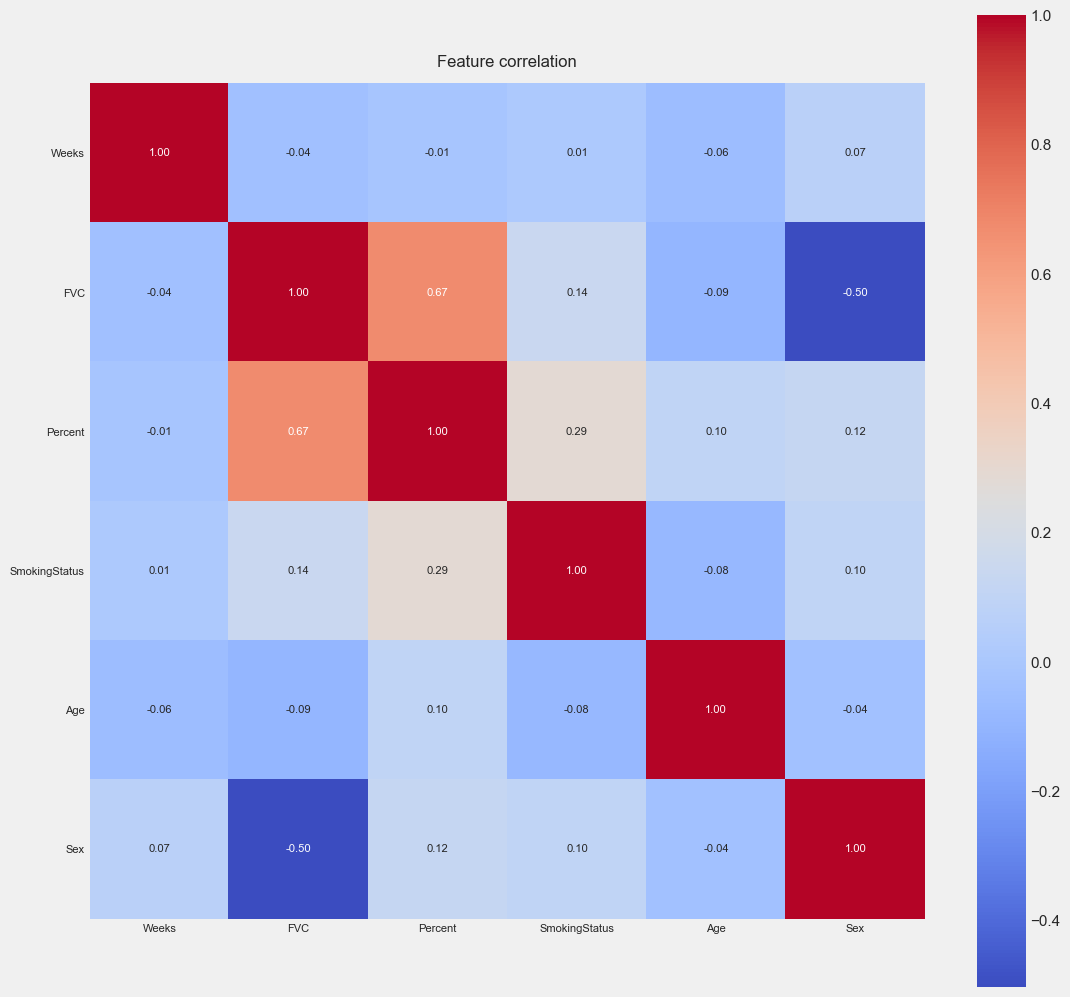

In [45]:
def plot_correlation_matrix(data_df, features=['Weeks', 'FVC', 'Percent', 'Age']):
    fig = plt.figure(figsize=(12, 12), dpi=100)
    correlation_df = data_df.copy()
    if 'SmokingStatus' in correlation_df.columns:
        correlation_df['SmokingStatus'] = correlation_df['SmokingStatus'].map({'Ex-smoker':0, 'Currently smokes': 1, 'Sever smoked': 2})
    if 'Sex' in correlation_df.columns:
        correlation_df['Sex'] = correlation_df['Sex'].map({'Male':0, 'Female': 1})
    sns.heatmap(correlation_df[features].corr(), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 8},  fmt='.2f')   

    plt.tick_params(axis='x', labelsize=8, rotation=0)
    plt.tick_params(axis='y', labelsize=8, rotation=0)
    plt.title('Feature correlation', size=12, pad=12)

    plt.show()
    
features = ['Weeks', 'FVC', 'Percent', 'SmokingStatus', 'Age', 'Sex']
plot_correlation_matrix(train_df, features)

#### [Conclusions] Correlation Tabular Data
* There is really low correlation between our features apart from FVC and Percentage.
* The correlation between percentage and FVC is expected as both are measuring lung capacity. We might want to omit one of those when training our model as information is redundant until certain extend.
* There is a bit of correlation between SmokingStatus which might indicate that a relationship between both features exists over time.

In [16]:
def plot_weeks_distribution(data_df):
    '''Plots the number of patient's visits per week in the dataset.
       :param data_df: data dataframe which should correspond with the format of the train and test dataset
    '''
    # plot weeks distribution
    train_df['Weeks'].value_counts().iplot(kind='bar',
                              xTitle='Week',
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='blue',
                              theme='pearl',
                              bargap=0.3,
                              gridcolor='white',
                              title='Weeks distribution')
plot_weeks_distribution(train_df)

## # Train.csv 
In the next part we are going to focus into creating the train dataset from our tabular data. We are going to create a single `train.csv` without headers with the following format:

* FVC 
* age
* base_FVC -> fvc of the first measurement 
* week -> num of weeks from first measurement
* percent
* sex
* smoking_status

In order to do that we need to calculate per raw in the train_df: base_fvc and week.

Later we need to normalise the values, and then we can create our `train.csv`

In [71]:
def preprocess_data(train_df, test_df):
    '''Processes and normalises both train dataset in order to prepare the data for the NN.
        It also calculates 
            - weeks_from_min: number of weeks since first visit
            - min_FVC: value of FVC in the first visit (base visit)
       :param data_df: data dataframe which corresponds with the format of the traindataset
    '''
    train_c_df = train_df.copy()
    test_c_df = test_df.copy()
    train_c_df['mode'] = 'train'
    test_c_df['mode'] = 'test'
    data_df = train_c_df.append([test_c_df])

    data_df['min_week'] = data_df['Weeks']

    data_df.loc[data_df['mode'] == 'test', 'min_week'] = np.nan
    data_df['min_week'] = data_df.groupby('Patient')['min_week'].transform('min')

    base_visit = data_df.loc[data_df.Weeks == data_df.min_week] # take records with min week.
    base_visit = base_visit[['Patient', 'FVC']].copy() # copy patient and fvc
    base_visit.columns = ['Patient', 'min_FVC'] # rename fvc to min_fvc as corresponds to min week
    base_visit['nb'] = 1
    base_visit['nb'] = base_visit.groupby('Patient')['nb'].transform('cumsum') # counts num of patients wit
    base_visit = base_visit[base_visit.nb == 1] # df with the base week for all the patients
    base_visit.drop('nb', axis=1, inplace=True)

    data_df = data_df.merge(base_visit, on='Patient', how='left') # merge data with base: ie add min_FVC column
    data_df['weeks_from_min'] = data_df['Weeks'] - data_df['min_week'] # difference 
    
    # normalise sex and smoking status in single columns per value
    COLS = ['Sex', 'SmokingStatus']
    for col in COLS:
        for mod in data_df[col].unique():
            data_df[mod] = (data_df[col] == mod).astype(int)

    data_df = data_df.drop(columns=['Patient', 'FVC', 'min_week', 'Sex', 'SmokingStatus'])
    
    #split train and test to normalise
    pp_train_df = data_df[data_df['mode'] == 'train']
    pp_test_df = data_df[data_df['mode'] == 'test']
    pp_train_df = pp_train_df.drop(columns=['mode'])
    pp_test_df = pp_test_df.drop(columns=['mode'])
    print('size of pp_test_df ->'+str(pp_test_df.shape[0]))
    # normilise dataframe
    min_max_scaler = preprocessing.MinMaxScaler()
    train_scaled = min_max_scaler.fit_transform(pp_train_df)
    test_scaled = min_max_scaler.fit_transform(pp_test_df)
    pp_train_df = pd.DataFrame(train_scaled, columns=pp_train_df.columns)
    pp_test_df = pd.DataFrame(test_scaled, columns=pp_test_df.columns)
    
    #puts FVC as the first columns
    pp_train_df.insert(0, 'FVC', train_df['FVC'])
    pp_test_df.insert(0, 'FVC', test_df['FVC'])
    return pp_train_df, pp_test_df
    

size of pp_test_df ->5


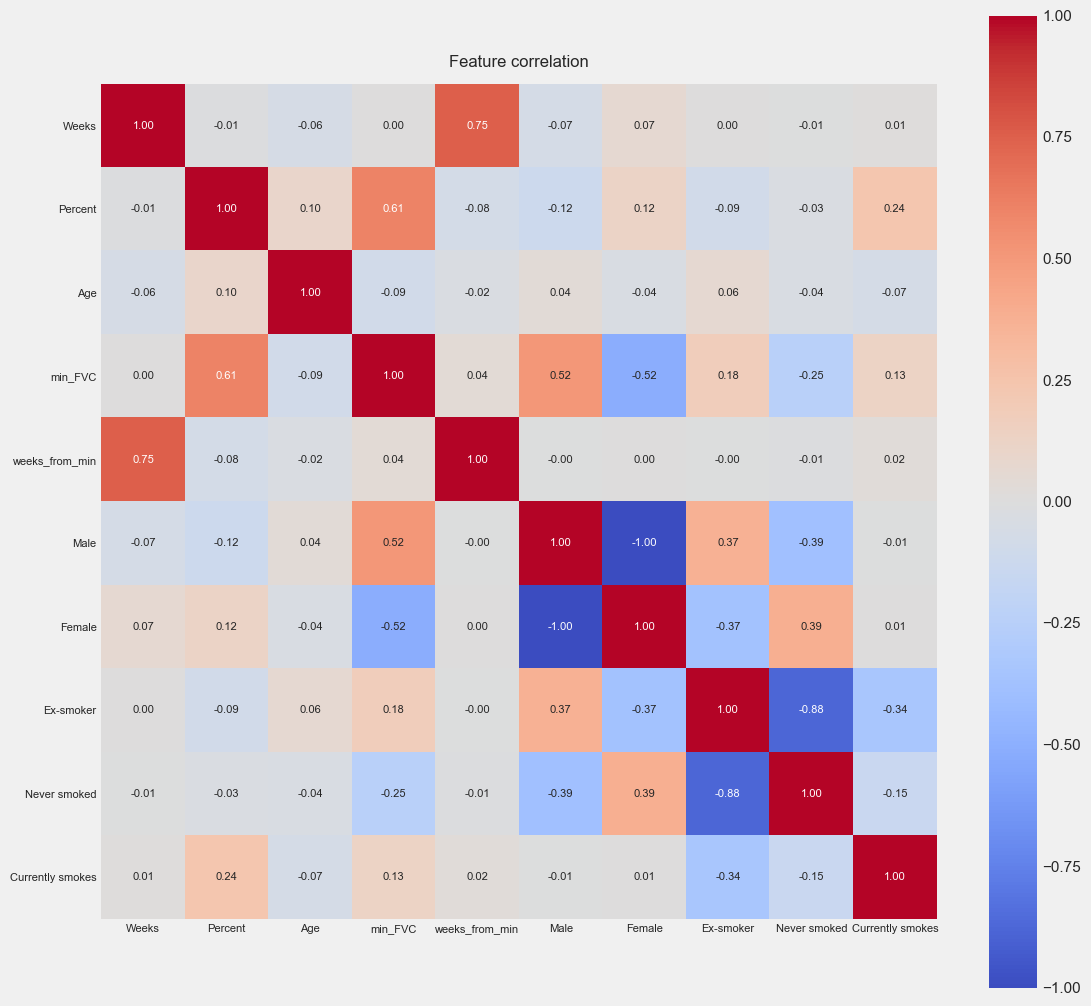

In [72]:
pp_train_df, pp_test_df = preprocess_data(train_df, test_df)

features = ['Weeks', 'Percent', 'Age', 'min_FVC', 'weeks_from_min', 'Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes']
plot_correlation_matrix(pp_train_df, features)

In [76]:
# save as csv without columns in s3
def make_csv(pp_train_df, pp_test_df, bucket_name='fibrosis-poc/data/'):
    '''method that creates a csv for train and test datasets. 
       :param pp_train_df: train dataset
       :param pp_test_df: test dataset
       :param bucket_name: Name of the bucket in which to store both csvs
       '''
    pp_train_df.to_csv(path_or_buf='data/pp_train.csv', header=False, index=False)
    pp_test_df.to_csv(path_or_buf='data/pp_test.csv', header=False, index=False)
    
    # todo upload to s3

In [77]:
from source.train import main
import argparse

# create csv
make_csv(pp_train_df, pp_test_df)

# Initiate the parser
args = argparse.ArgumentParser()

# Add long and short argument
args.batch_size= 64
args.data_dir='data/' 
args.seed= 1
args.lr= 3e-3
args.epochs= 1000
args.in_tabular_features= pp_train_df.shape[1]
args.quantiles= [0.2, 0.5, 0.8]
args.model_dir= 'data/model_dir/'
    
main(args)

Get data loader.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

# TODO
* define final train ds mapping sex and smoking status to numbers.
* run a linear regression model using pytorch or an existing scikit-learn model.
* conclussions.

*Confidence interval*: predicts the distribution of estimates of the true population mean or other quantity of interest that cannot be observed.

https://www.kaggle.com/havinath/eda-observations-visualizations-pytorch

In [130]:
import copy
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from torch.utils.data import Dataset
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange
from time import time

ModuleNotFoundError: No module named 'tqdm'

In [95]:
model_dir = 'data/model_dir'
num_kfolds = 5
batch_size = 32
learning_rate = 3e-3
num_epochs = 1000
es_patience = 8
quantiles = (0.2, 0.5, 0.8)
model_name ='manu_descartes'

In [96]:
class ClinicalDataset(Dataset):
    def __init__(self, train_df, test_df, mode, transform=None):
        self.transform = transform
        self.mode = mode

        train_df.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])
        chunk = test_df

        sub = pd.read_csv(Path(root_dir)/"sample_submission.csv")
        sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
        sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
        sub = sub[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]
        sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

        tr['WHERE'] = 'train'
        chunk['WHERE'] = 'val'
        sub['WHERE'] = 'test'
        
        #data contains train, validation and test with a field to specify what is 'where'
        data = tr.append([chunk, sub])
        
        # calculates the min week per each patients and adds a column for that. For test dataset fills a nan
        data['min_week'] = data['Weeks']
        data.loc[data.WHERE == 'test', 'min_week'] = np.nan
        data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

        
        base = data.loc[data.Weeks == data.min_week] # take records with min week.
        base = base[['Patient', 'FVC']].copy() # copy patient and fvc
        base.columns = ['Patient', 'min_FVC'] # rename fvc to min_fvc as corresponds to min week
        base['nb'] = 1
        base['nb'] = base.groupby('Patient')['nb'].transform('cumsum') # counts num of patients wit
        base = base[base.nb == 1] # df with the base week for all the patients
        base.drop('nb', axis=1, inplace=True)

        data = data.merge(base, on='Patient', how='left') # merge data with base: ie add min_FVC column
        data['base_week'] = data['Weeks'] - data['min_week'] # difference between records week and min week
        del base
        
        ## now data has min_FVC and base_week columns

        # here we normalise sex and smoking status
        COLS = ['Sex', 'SmokingStatus']
        self.FE = []
        for col in COLS:
            for mod in data[col].unique():
                self.FE.append(mod)
                data[mod] = (data[col] == mod).astype(int)
        
        # here we normalise age, min_FVC, week and percent
        data['age'] = (data['Age'] - data['Age'].min()) / \
                      (data['Age'].max() - data['Age'].min())
        data['BASE'] = (data['min_FVC'] - data['min_FVC'].min()) / \
                       (data['min_FVC'].max() - data['min_FVC'].min())
        data['week'] = (data['base_week'] - data['base_week'].min()) / \
                       (data['base_week'].max() - data['base_week'].min())
        data['percent'] = (data['Percent'] - data['Percent'].min()) / \
                          (data['Percent'].max() - data['Percent'].min())
        self.FE += ['age', 'percent', 'week', 'BASE']

        self.raw = data.loc[data.WHERE == mode].reset_index()
        del data

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = {
            'patient_id': self.raw['Patient'].iloc[idx],
            'features': self.raw[self.FE].iloc[idx].values,
            'target': self.raw['FVC'].iloc[idx]
        }
        if self.transform:
            sample = self.transform(sample)

        return sample

    def group_kfold(self, n_splits):
        gkf = GroupKFold(n_splits=n_splits)
        groups = self.raw['Patient']
        for train_idx, val_idx in gkf.split(self.raw, self.raw, groups):
            train = Subset(self, train_idx)
            val = Subset(self, val_idx)
            yield train, val

   ## not used         
    def group_split(self, test_size=0.2):
        """To test no-kfold
        """
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size)
        groups = self.raw['Patient']
        idx = list(gss.split(self.raw, self.raw, groups))
        train = Subset(self, idx[0][0])
        val = Subset(self, idx[0][1])
        return train, val

In [97]:
class QuantModel(nn.Module):
    def __init__(self, in_tabular_features=9, out_quantiles=3):
        super(QuantModel, self).__init__()
        self.fc1 = nn.Linear(in_tabular_features, 100)
        #self.bn1 = nn.BatchNorm1d(num_features=100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_quantiles)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        #x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


def quantile_loss(preds, target, quantiles):
    #assert not target.requires_grad
    assert len(preds) == len(target)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

def metric_loss(pred_fvc,true_fvc):
        #Implementation of the metric in pytorch
    sigma = pred_fvc[:, 2] - pred_fvc[:, 0]
    true_fvc=torch.reshape(true_fvc,pred_fvc[:,1].shape)
    sigma_clipped=torch.clamp(sigma,min=70)
    delta=torch.clamp(torch.abs(pred_fvc[:,1]-true_fvc),max=1000)
    metric=torch.div(-torch.sqrt(torch.tensor([2.0]).to(device))*delta,sigma_clipped)-torch.log(torch.sqrt(torch.tensor([2.0]).to(device))*sigma_clipped)
    return metric

NameError: name 'nn' is not defined

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
models = []

# Load the data
data = ClinicalDataset(root_dir=root_dir, mode='train')
folds = data.group_kfold(num_kfolds)
#t0 = time()
#if len(testfiles) == 5:
    #f= open("/kaggle/working/training.log","w+") 
for fold, (trainset, valset) in enumerate(folds):
    best_val = None
    patience = es_patience
    model = QuantModel().to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = Adam(params, lr=learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    # to optimise the lr
    lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)


    print("=="*20+"Fold "+str(fold+1)+"=="*20)
    Path(model_dir).mkdir(parents=True, exist_ok=True)
    model_path = model_dir+f'/fold_{fold}.pth'
    now = datetime.now()
    dataset_sizes = {'train': len(trainset), 'val': len(valset)}
    dataloaders = {
            'train': DataLoader(trainset, batch_size=batch_size,
                                shuffle=True, num_workers=2),
            'val': DataLoader(valset, batch_size=batch_size,
                              shuffle=False, num_workers=2)
    }
    for epoch in range(num_epochs):
        start_time = time()
        itr = 1
        model.train()
        train_losses =[]
        for batch in dataloaders['train']:
            inputs = batch['features'].float().to(device)
            targets = batch['target'].to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                preds = model(inputs)
                # use the quantile loss for backpropagation in the train dataset
                loss = quantile_loss(preds, targets, quantiles)
                train_losses.append(loss.tolist())
                loss.backward()
                optimizer.step()
           
            if itr % 50 == 0:
                print(f"Epoch #{epoch+1} Iteration #{itr} loss: {loss}")
            itr += 1
            
        model.eval()
        all_preds = []
        all_targets = []
        for batch in dataloaders['val']:
            inputs = batch['features'].float().to(device)
            targets = batch['target']
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                preds = model(inputs)
                all_preds.extend(preds.detach().cpu().numpy().tolist())
                all_targets.extend(targets.numpy().tolist()) # np.append(an_array, row_to_append, 0)
        all_preds =torch.FloatTensor(all_preds)
        all_targets =torch.FloatTensor(all_targets)
        # metric loss used for loss calculation of validation ds
        val_metric_loss = metric_loss(all_preds, all_targets)
        val_metric_loss = torch.mean(val_metric_loss).tolist()

        lr_scheduler.step()
        print(f"Epoch #{epoch+1}","Training loss : {0:.4f}".format(np.mean(train_losses)),"Validation LLL : {0:.4f}".format(val_metric_loss),"Time taken :",str(timedelta(seconds=time() - start_time))[:7])
        
        ## saving model if metric validation has improved, otherwise if for es_patience iterations metric not improving then break
        if not best_val:
            best_val = val_metric_loss  # So any validation roc_auc we have is the best one for now
            print("Info : Saving model")
            torch.save(copy.deepcopy(model.state_dict()), model_path)  # Saving the model
        if val_metric_loss > best_val:
            print("Info : Saving model as Laplace Log Likelihood is increased from {0:.4f}".format(best_val),"to {0:.4f}".format(val_metric_loss))
            best_val = val_metric_loss
            patience = es_patience  # Resetting patience since we have new best validation accuracy
            torch.save(copy.deepcopy(model.state_dict()), model_path)  # Saving current best model torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best Validation Laplace Log Likelihood: {:.3f}'.format(best_val))
                break
    model.load_state_dict(torch.load(model_path))
    models.append(model)